In [16]:
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import NLLLoss, BCEWithLogitsLoss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from torch_geometric.loader import DataLoader
import copy

Setting seeds for reproducibility

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
path = "../../graphs/tx_graph/"
file = path + "tx_transaction_graph_timestamp_1.pkl"
with open(file, "rb") as f:
    graph = pickle.load(f)

In [168]:
def feature_matrix(graph, as_pandas=False):
    #Returns a feature matrix of an input graph as a numpy array (default) or pandas df (if specified)
    attr_dict = dict(graph.nodes(data=True))
    X = pd.DataFrame.from_dict(attr_dict, orient='index')
    if as_pandas:
        return X
    return X.to_numpy()

In [19]:
attrs = list(next(iter(graph.nodes(data=True)))[1].keys())
attrs.remove("class")
print(len(attrs))

183


# DATA PIPELINE
We noticed that some of the features are way bigger in magnitude than others, hence we will normalize.\
Some values are also na so we will inject them with the column mean. 

In [4]:
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import MinMaxScaler

def graph_to_data(graph, standardize=True, minmax=False):
    attrs = list(next(iter(graph.nodes(data=True)))[1].keys())
    attrs.remove("class")

    data = from_networkx(graph, group_node_attrs=attrs)
    
    column_mean = data.x.nanmean(dim=0)
    inds = torch.where(torch.isnan(data.x))
    data.x[inds] = column_mean[inds[1]] #input means where there are nan values

    if standardize and minmax:
        raise Exception("Cannot standardize and minmax at the same time")
    
    if standardize:
        mean = data.x.mean(dim=0)
        std = data.x.std(dim=0) + 1e-6
        data.x = (data.x - mean) / std
    
    if minmax:
        scaler = MinMaxScaler()
        data.x = torch.tensor(scaler.fit_transform(data.x), dtype=torch.float32)

    labels = [graph.nodes[n]["class"] for n in graph.nodes()]
    data.y = torch.tensor(labels)
    return data

Creating a dataset where each graph is standardized individually

In [ ]:
#This takes around 35 seconds
dataset = []
for i in range(1, 50):
    file = path + f"tx_transaction_graph_timestamp_{i}.pkl"
    with open(file, "rb") as f:
        graph = pickle.load(f)
        dataset.append(graph_to_data(graph))

with open("individually_standardized_graphs", "wb") as f:
    pickle.dump(dataset, f)

In [19]:


with open("individually_standardized_graphs", "rb") as f:
    dataset = pickle.load(f)

train_dataset = dataset[:30]
val_dataset = dataset[30:40]
test_dataset = dataset[40:]

train_loader = DataLoader(train_dataset, shuffle=True)
val_loader = DataLoader(val_dataset)
test_loader = DataLoader(test_dataset)

Creating a dataset where the standardizer is trained on the whole train data

In [152]:
from sklearn.preprocessing import StandardScaler

raw_dataset = []
for i in range(1, 50):
    file = path + f"tx_transaction_graph_timestamp_{i}.pkl"
    with open(file, "rb") as f:
        graph = pickle.load(f)
        raw_dataset.append(graph_to_data(graph, False, False))

with open("raw_graphs", "wb") as f:
    pickle.dump(raw_dataset, f)


In [183]:
with open("raw_graphs", "rb") as f:
    raw_dataset = pickle.load(f)

train_tensor = torch.cat([g.x for g in raw_dataset[:30]])

standard_scaler = StandardScaler()

standard_scaler.fit(train_tensor)

for graph in raw_dataset:
    graph.x = torch.Tensor(standard_scaler.transform(graph.x))

with open("batch_standardized_graphs", "wb") as f:
    pickle.dump(raw_dataset, f)

In [8]:
def load_data(data_type):
    torch.manual_seed(42)
    
    if data_type == "raw":
        fname = "raw_graphs"
    elif data_type == "batch":
        fname = "batch_standardized_graphs"
    elif data_type == "individual":
        fname = "individually_standardized_graphs"
    else:
        raise Exception("Invalid argument, supply one of the following [`raw`, `batch`, `individual`]")

    with open(fname, "rb") as f:
        dataset = pickle.load(f)

    train_dataset = dataset[:30]
    val_dataset = dataset[30:40]
    test_dataset = dataset[40:]

    train_loader = DataLoader(train_dataset, shuffle=True)
    val_loader = DataLoader(val_dataset)
    test_loader = DataLoader(test_dataset)

    return train_loader, val_loader, test_loader

# Finding out training labels ratio

In [20]:
from collections import Counter
all_y = []
for dataset in train_dataset:
    all_y.extend(dataset.y.tolist())

counter = Counter(all_y)
counter.items()
illicit = counter[1.0]
licit = counter[2.0]

illicit_ratio = illicit / (illicit + licit)
licit_ratio = licit / (illicit + licit)

print(illicit_ratio, licit_ratio)

0.10979371863965806 0.890206281360342


# Defining the simple Graph Convolutional NN

In [45]:
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, ):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            if num_layers == 1:
                self.convs.append(GCNConv(input_dim, output_dim))
            elif i == 0:
                self.convs.append(GCNConv(input_dim, hidden_dim))
            elif i == (num_layers - 1):
                self.convs.append(GCNConv(hidden_dim, output_dim))
            else:
                self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.lns = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)])
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout

    def forward(self, x, adj_t):
        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            # print("After Conv:")
            # print(x)
            if i < len(self.lns):
                x = self.lns[i](x)
                # print("After norm:")
                # print(x)
                x = torch.nn.functional.relu(x)
                # print("After RELU:")
                # print(x)
                x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
                # print(x)
        return self.softmax(x) #USE THIS IF USING NLL LOSS
        # return(x)

In [4]:
def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    count = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        y = batch.y

        mask = y != 3

        if mask.sum() == 0:   # skip empty batch
            continue

        #Need to remap this to work with nll loss. Now 0 is illicit and 1 is licit.
        y_remapped = (y[mask] - 1).long()

        # print(out[mask][:5], y_remapped[:5])
        
        loss = loss_fn(out[mask], y_remapped)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1
    # print(count, total_loss)
    return total_loss / max(count, 1)

F1 score can take an argument "pos_label" with which we set the positive label. In our case, illicit cases count as positives.

In [5]:
@torch.no_grad()
def test(model, loader, loss_fn, bincount=False, full_report=False):
    model.eval()
    total_loss = 0
    count = 0

    all_predictions = []
    all_y = []

    for batch in loader:

        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        y = batch.y
        
        mask = y != 3

        if mask.sum() == 0:   # skip empty batch
            continue

        y_remapped = (y[mask] - 1).long()

        masked_out = out[mask]
        predicted_classes = masked_out.argmax(dim=1)

        if bincount:
            print(predicted_classes.bincount())
        
        all_predictions.extend(predicted_classes.cpu())
        all_y.extend(y_remapped.cpu())

        total_loss += loss_fn(masked_out, y_remapped).item()
        count += 1
    
    if full_report:
        return (precision_score(all_y, all_predictions, pos_label=0),
                recall_score(all_y, all_predictions, pos_label=0),
                f1_score(all_y, all_predictions, pos_label=0),
                f1_score(all_y, all_predictions, average="macro"),
                f1_score(all_y, all_predictions, average="micro"),
                total_loss/count)    

    return f1_score(all_y, all_predictions, pos_label=0), total_loss/count

# LEARNING ALGORITHM PARAMETERS

In [6]:
args = {
      'device': device,
      'num_layers': 3,
      'hidden_dim': 256,
      'dropout': 0.5,
      'lr': 0.0001,
      'epochs': 100,
  }

# MODEL INSTANTIATION

In [46]:
np.random.seed(42)
torch.manual_seed(42)

#Create the model
model = GCN(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = NLLLoss()
# weight=torch.tensor([licit_ratio, illicit_ratio]).to(device)
#Load the data
train_loader, val_loader, test_loader = load_data("batch") #"batch", "individual", or "raw" to get their corresponding data loaders 

In [47]:
test_losses = []
val_losses = []

for epoch in range(args["epochs"]):
    train_result = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    test_losses.append(train_result)
    val_losses.append(val_loss)
    
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_result} | Validation f1: {val_f1} | Validation loss: {val_loss}")

Epoch: 0 | Train loss: 0.7684923628966014 | Validation f1: 0.0 | Validation loss: 0.3746154375374317
Epoch: 10 | Train loss: 0.2588782362639904 | Validation f1: 0.5129118432769367 | Validation loss: 0.26305423080921175
Epoch: 20 | Train loss: 0.222340506563584 | Validation f1: 0.5857988165680473 | Validation loss: 0.254894894361496
Epoch: 30 | Train loss: 0.20296214185655118 | Validation f1: 0.5830828681837699 | Validation loss: 0.24552337676286698
Epoch: 40 | Train loss: 0.1877137955278158 | Validation f1: 0.5784716516023007 | Validation loss: 0.2488032579421997
Epoch: 50 | Train loss: 0.1783167311300834 | Validation f1: 0.5960502692998204 | Validation loss: 0.23260284066200257
Epoch: 60 | Train loss: 0.17145549828807513 | Validation f1: 0.6056143580303728 | Validation loss: 0.22540684491395951
Epoch: 70 | Train loss: 0.16451315879821776 | Validation f1: 0.6164874551971327 | Validation loss: 0.22314439117908477
Epoch: 80 | Train loss: 0.1567621429761251 | Validation f1: 0.619546247818

<Axes: >

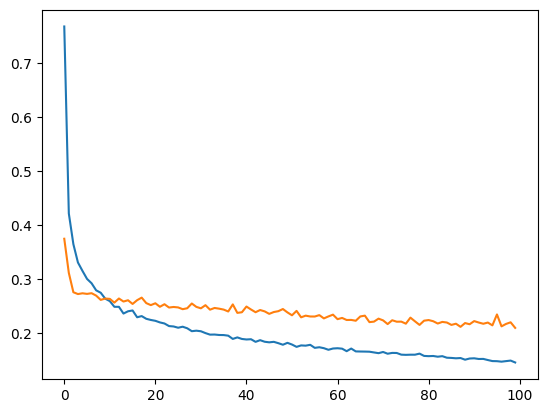

In [48]:
sns.lineplot(x=range(len(test_losses)), y=test_losses)
sns.lineplot(x=range(len(test_losses)), y=val_losses)


In [49]:
test(model, test_loader, loss_fn, True)

tensor([ 111, 1021], device='cuda:0')
tensor([ 141, 2013], device='cuda:0')
tensor([  11, 1359], device='cuda:0')
tensor([  18, 1573], device='cuda:0')
tensor([  26, 1195], device='cuda:0')
tensor([ 13, 699], device='cuda:0')
tensor([  4, 842], device='cuda:0')
tensor([  3, 468], device='cuda:0')
tensor([  0, 476], device='cuda:0')


(0.3595769682726204, 0.18570315589507422)

In [35]:
torch.save(model.state_dict(), "GCN_model_weights.pth")

# Finding the best GCN (without grid search for now)

In [63]:
import copy

train_loader, val_loader, test_loader = load_data("batch")

np.random.seed(42)
torch.manual_seed(42)
model = GCN(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = NLLLoss()
# weight=torch.tensor([licit_ratio, illicit_ratio]).to(device)
best_f1 = -np.inf
best_model = None

for epoch in range(args["epochs"]):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    if val_f1 > best_f1:
        best_f1= val_f1
        best_model = copy.deepcopy(model)
        print(f"New best model!  F1: {val_f1}, loss: {val_loss}")

New best model!  F1: 0.0, loss: 0.3903261199593544
New best model!  F1: 0.04508566275924256, loss: 0.29470568150281906
New best model!  F1: 0.38367844092570036, loss: 0.2730802372097969
New best model!  F1: 0.4204609331084879, loss: 0.26937720775604246
New best model!  F1: 0.4600896860986547, loss: 0.2794589281082153
New best model!  F1: 0.46160754378087115, loss: 0.27498871088027954
New best model!  F1: 0.4616822429906542, loss: 0.2670536622405052
New best model!  F1: 0.4755671902268761, loss: 0.2720039561390877
New best model!  F1: 0.4816849816849817, loss: 0.2630210667848587
New best model!  F1: 0.5144775493075955, loss: 0.27040141969919207
New best model!  F1: 0.5299710624224886, loss: 0.26962410658597946
New best model!  F1: 0.5349048050770625, loss: 0.2566190451383591
New best model!  F1: 0.5417362270450752, loss: 0.2646128416061401
New best model!  F1: 0.5676483141271874, loss: 0.26131670773029325
New best model!  F1: 0.5728070175438597, loss: 0.2566557601094246
New best model! 

In [64]:
test(best_model, test_loader, loss_fn, True)

tensor([ 109, 1023], device='cuda:0')
tensor([ 154, 2000], device='cuda:0')
tensor([  14, 1356], device='cuda:0')
tensor([  22, 1569], device='cuda:0')
tensor([  28, 1193], device='cuda:0')
tensor([ 12, 700], device='cuda:0')
tensor([  5, 841], device='cuda:0')
tensor([  3, 468], device='cuda:0')
tensor([  2, 474], device='cuda:0')


(0.38717067583046966, 0.19030466261837217)

In [108]:
torch.save(best_model.state_dict(), "GCN_model_weights.pth")

In [13]:
from itertools import product

parameters = {
      'num_layers': [1, 3, 5],
      'hidden_dim': [128, 256, 512],
      'dropout': [0.1, 0.3, 0.5],
      'lr': [0.0001, 0.001, 0.01, 0.1],
  }

print(len(list(product(*parameters.values()))))


108


# GRID SEARCH CODE

In [14]:
def find_best_model(model_class, parameters, epochs, device, train_loader, val_loader):
    
    best_f1_model = None
    best_loss_model = None

    best_f1 = -np.inf
    best_loss = np.inf

    for num_layers, hidden_dim, dropout, lr in list(product(*parameters.values())):

        np.random.seed(42)
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)

        model = model_class(183, #hardcoded for now
                            hidden_dim,
                            2,   #hardcoded for now
                            num_layers,
                            dropout
                            ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = NLLLoss()
# weight=torch.tensor([licit_ratio, illicit_ratio]).to(device)
        for epoch in range(epochs):
            train_loss = train(model, train_loader, optimizer, loss_fn)
            val_f1, val_loss = test(model, val_loader, loss_fn)

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_f1_model = copy.deepcopy(model)
                print("Found new best f1 model: Args: ", num_layers, hidden_dim, dropout, lr, epoch, "F1: ", val_f1)

            if val_loss < best_loss:
                best_loss = val_loss
                best_loss_model = copy.deepcopy(model)
                print("Found new best loss model: Args: ", num_layers, hidden_dim, dropout, lr, epoch, "Loss: ", val_loss)

    return best_f1_model, best_loss_model

In [17]:
train_loader, val_loader, test_loader = load_data("batch")
best_f1_model, best_loss_model = find_best_model(GCN, parameters, 100, device, train_loader, val_loader)

Found new best f1 model: Args:  1 128 0.1 0.0001 0 F1:  0.15336039693279205
Found new best loss model: Args:  1 128 0.1 0.0001 0 Loss:  0.5053310588002204
Found new best f1 model: Args:  1 128 0.1 0.0001 1 F1:  0.204655248133509
Found new best loss model: Args:  1 128 0.1 0.0001 1 Loss:  0.474496091902256
Found new best f1 model: Args:  1 128 0.1 0.0001 2 F1:  0.28010247651579845
Found new best loss model: Args:  1 128 0.1 0.0001 2 Loss:  0.4362235859036446
Found new best f1 model: Args:  1 128 0.1 0.0001 3 F1:  0.34103827207275483
Found new best loss model: Args:  1 128 0.1 0.0001 3 Loss:  0.4341555953025818
Found new best f1 model: Args:  1 128 0.1 0.0001 4 F1:  0.3553903345724907
Found new best loss model: Args:  1 128 0.1 0.0001 4 Loss:  0.4223642572760582
Found new best f1 model: Args:  1 128 0.1 0.0001 5 F1:  0.37380530973451326
Found new best loss model: Args:  1 128 0.1 0.0001 5 Loss:  0.41722259372472764
Found new best f1 model: Args:  1 128 0.1 0.0001 6 F1:  0.381637547105173

In [ ]:
torch.save(best_f1_model.state_dict(), "GCN_best_f1_model_weights.pth")
torch.save(best_loss_model.state_dict(), "GCN_best_loss_model_weights.pth")

In [25]:
precision, recall, f1, macro, micro, loss = test(best_f1_model, test_loader, loss_fn, True, True)
print(f"precision: {precision}, recall: {recall}, F1: {f1}, macro: {macro}, micro: {micro}")

tensor([142, 990], device='cuda:0')
tensor([ 383, 1771], device='cuda:0')
tensor([  84, 1286], device='cuda:0')
tensor([  83, 1508], device='cuda:0')
tensor([  33, 1188], device='cuda:0')
tensor([ 24, 688], device='cuda:0')
tensor([ 27, 819], device='cuda:0')
tensor([  4, 467], device='cuda:0')
tensor([  5, 471], device='cuda:0')
precision: 0.27261146496815286, recall: 0.4083969465648855, F1: 0.3269671504965623, macro: 0.6398477969577837, micro: 0.9116614860122331


# Defining GraphSAGE

In [39]:
from torch_geometric.nn import SAGEConv
class SAGE(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, ):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()   
        for i in range(num_layers):
            if num_layers == 1:
                self.convs.append(SAGEConv(input_dim, output_dim))
            elif i == 0:
                self.convs.append(SAGEConv(input_dim, hidden_dim))
            elif i == (num_layers - 1):
                self.convs.append(SAGEConv(hidden_dim, output_dim))
            else:
                self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.lns = torch.nn.ModuleList([torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)])
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dropout

    def forward(self, x, adj_t):
        for i in range(len(self.convs)):
            x = self.convs[i](x, adj_t)
            # print("After Conv:")
            # print(x)
            if i < len(self.lns):
                x = self.lns[i](x)
                # print("After norm:")
                # print(x)
                x = torch.nn.functional.relu(x)
                # print("After RELU:")
                # print(x)
                x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
                # print(x)
        return self.softmax(x) #USE THIS IF USING NLL LOSS
        # return(x)

In [40]:
model = SAGE(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = NLLLoss()

train_loader, val_loader, test_loader = load_data("batch")

In [33]:
test_losses = []
val_losses = []


for epoch in range(50):
    train_result = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    test_losses.append(train_result)
    val_losses.append(val_loss)
    
    if epoch%10 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_result} | Validation f1: {val_f1} | Validation loss: {val_loss}")

Epoch: 0 | Train loss: 0.42245582193136216 | Validation f1: 0.0018726591760299626 | Validation loss: 0.28060195297002793
Epoch: 10 | Train loss: 0.15259616052110989 | Validation f1: 0.6963028169014085 | Validation loss: 0.19085482656955718
Epoch: 20 | Train loss: 0.11058712316056092 | Validation f1: 0.6991005723630417 | Validation loss: 0.1955360949039459
Epoch: 30 | Train loss: 0.0942510940755407 | Validation f1: 0.7474931631722881 | Validation loss: 0.16744535490870477
Epoch: 40 | Train loss: 0.07823459338396788 | Validation f1: 0.7202797202797203 | Validation loss: 0.19653605967760085


<Axes: >

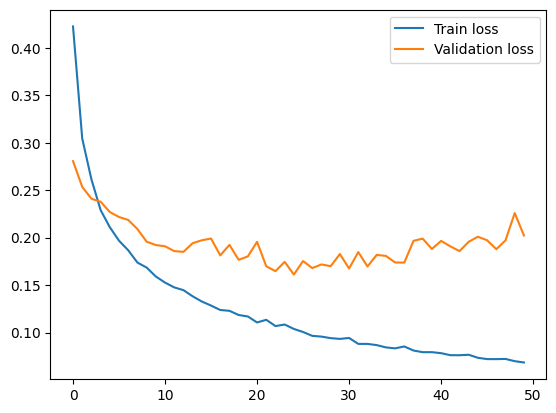

In [34]:
sns.lineplot(x=range(len(test_losses)), y=test_losses, label="Train loss")
sns.lineplot(x=range(len(test_losses)), y=val_losses, label="Validation loss")


In [35]:
test(model, test_loader, loss_fn, True, True)

tensor([143, 989], device='cuda:0')
tensor([ 226, 1928], device='cuda:0')
tensor([  27, 1343], device='cuda:0')
tensor([  33, 1558], device='cuda:0')
tensor([  33, 1188], device='cuda:0')
tensor([  5, 707], device='cuda:0')
tensor([  8, 838], device='cuda:0')
tensor([  2, 469], device='cuda:0')
tensor([  5, 471], device='cuda:0')


(0.5,
 0.4599236641221374,
 0.47912524850894633,
 0.725729466915508,
 0.9474581369698185,
 0.22115664266877705)

# Grid search on SAGE

In [41]:
train_loader, val_loader, test_loader = load_data("batch")
best_f1_sage_model, best_loss_sage_model = find_best_model(SAGE, parameters, 100, device, train_loader, val_loader)

Found new best f1 model: Args:  1 128 0.1 0.0001 0 F1:  0.118479579458148
Found new best loss model: Args:  1 128 0.1 0.0001 0 Loss:  0.9318406373262406
Found new best f1 model: Args:  1 128 0.1 0.0001 1 F1:  0.13689482470784642
Found new best loss model: Args:  1 128 0.1 0.0001 1 Loss:  0.7889735758304596
Found new best f1 model: Args:  1 128 0.1 0.0001 2 F1:  0.16836461126005361
Found new best loss model: Args:  1 128 0.1 0.0001 2 Loss:  0.696525838971138
Found new best f1 model: Args:  1 128 0.1 0.0001 3 F1:  0.1952881067272211
Found new best loss model: Args:  1 128 0.1 0.0001 3 Loss:  0.6281385987997055
Found new best f1 model: Args:  1 128 0.1 0.0001 4 F1:  0.2076167076167076
Found new best loss model: Args:  1 128 0.1 0.0001 4 Loss:  0.5630933254957199
Found new best f1 model: Args:  1 128 0.1 0.0001 5 F1:  0.2306456794089303
Found new best loss model: Args:  1 128 0.1 0.0001 5 Loss:  0.5224840015172958
Found new best f1 model: Args:  1 128 0.1 0.0001 6 F1:  0.24436860068259386


In [156]:
import copy

train_loader, val_loader, test_loader = load_data("batch")

np.random.seed(42)
torch.manual_seed(42)
model = SAGE(183, #hardcoded for now
            args["hidden_dim"],
            2,   #hardcoded for now
            args["num_layers"],
            args["dropout"]
            ).to(args["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = NLLLoss(weight=torch.tensor([licit_ratio, illicit_ratio]).to(device))

best_loss = np.inf
best_model = None
best_model_epoch = None

for epoch in range(args["epochs"]):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_f1, val_loss = test(model, val_loader, loss_fn)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        print(f"New best model!  F1: {val_f1}, loss: {val_loss}")

New best model!  F1: 0.418286915396742, loss: 0.5811291992664337
New best model!  F1: 0.35853293413173654, loss: 0.5508233636617661
New best model!  F1: 0.47551117451260105, loss: 0.5293816417455673
New best model!  F1: 0.5153276955602537, loss: 0.46150161921977995
New best model!  F1: 0.5554605075563159, loss: 0.45426764339208603
New best model!  F1: 0.5782766990291263, loss: 0.4467103973031044
New best model!  F1: 0.5726215329555622, loss: 0.4333152577280998
New best model!  F1: 0.5711764705882353, loss: 0.4280269369482994


In [44]:
precision, recall, f1, macro, micro, loss = test(best_f1_sage_model, test_loader, loss_fn, True, True)
print(f"precision: {precision}, recall: {recall}, F1: {f1}, macro: {macro}, micro: {micro}")

tensor([  96, 1036], device='cuda:0')
tensor([ 173, 1981], device='cuda:0')
tensor([  19, 1351], device='cuda:0')
tensor([   8, 1583], device='cuda:0')
tensor([   7, 1214], device='cuda:0')
tensor([  5, 707], device='cuda:0')
tensor([  7, 839], device='cuda:0')
tensor([  0, 471], device='cuda:0')
tensor([  1, 475], device='cuda:0')
precision: 0.7373417721518988, recall: 0.4446564885496183, F1: 0.5547619047619048, macro: 0.7675934510724629, micro: 0.9624987466158629


# Trying the RF approach like they did in the paper

In [148]:
from sklearn.ensemble import RandomForestClassifier

with open("batch_standardized_graphs", "rb") as f:
    graphs = pickle.load(f)

train_table = torch.cat([graph.x for graph in graphs[:35]])
train_labels = torch.cat([graph.y for graph in graphs[:35]])

mask = train_labels != 3

train_table = train_table[mask]
train_labels = train_labels[mask]

rf_classifier = RandomForestClassifier(n_estimators=50)
rf_classifier.fit(train_table, train_labels)

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [149]:
test_table = torch.cat([graph.x for graph in graphs[35:]])
test_labels = torch.cat([graph.y for graph in graphs[35:]])

mask = test_labels != 3

test_table = test_table[mask]
test_labels = test_labels[mask]

print("Precision: ", precision_score(test_labels, rf_classifier.predict(test_table), pos_label=1))
print("Recall: ", recall_score(test_labels, rf_classifier.predict(test_table), pos_label=1))
print("F1: ", f1_score(test_labels, rf_classifier.predict(test_table), pos_label=1))

Precision:  0.9678456591639871
Recall:  0.6681465038845728
F1:  0.7905449770190414
